In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )
print(gammapy)

loaded gammapy version: 1.1.dev320+g92a6eb9f4 
Supposed to be 1.0 (21-12-2022)
<module 'gammapy' from '/home/hpc/caph/mppi045h/gammapy/gammapy/__init__.py'>


$\mathcal{L} = \exp(-\lambda) \frac{1}{n!} \lambda ^n$ \
for easier minimalisation: \
$-2 \log (\mathcal{L})= - 2 n \log (\lambda) + 2 \lambda $

In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PowerLawNuisanceSpectralModel,
    PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation import sys_dataset


## Read dataset

spatial binsize =  [0.08] deg
penality 0 []
MapDataset
----------

  Name                            : lNSKd4AH 

  Total counts                    : 388209 
  Total background counts         : 360331.31
  Total excess counts             : 27877.69

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -924522.99

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Tem

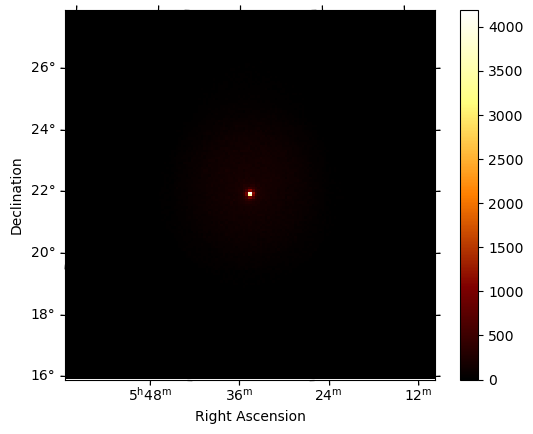

In [3]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'


dataset_load = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_load = dataset_load.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models([source_model])

bkg_model = FoVBackgroundModel(dataset_name=dataset_load.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_load.models = models

dataset_asimov = dataset_load.copy()
dataset_asimov.counts = dataset_load.npred()
models = Models(source_model.copy(name="Source"))
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models

    
dataset_load.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_load.geoms["geom"].width[1] / dataset_load.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_load)

## Asimov Cases

In [4]:
factor_neg = -0.2
factor_pos = +0.2
sigma = 0.2

in modelbase:

def __init_subclass__(cls, **kwargs):
        # Add parameters list on the model sub-class (not instances)
        cls.default_parameters = Parameters(
            [_ for _ in cls.__dict__.values() if isinstance(_, Parameter)]
        )
        
        

In [5]:
sys_d_cor = sys_dataset(dataset_asimov, 0, False)
dataset_cor_N = sys_d_cor.create_dataset_N(sigma)

sys_d_neg = sys_dataset(dataset_asimov, factor_neg, False)
dataset_neg_N = sys_d_neg.create_dataset_N(sigma)

sys_d_pos = sys_dataset(dataset_asimov, factor_pos, False)
dataset_pos_N = sys_d_pos.create_dataset_N(sigma)


penalising_covmatrix = [[sigma,sigma * 0.99], [sigma * 0.99, sigma]]
penalising_invcovmatrix = np.linalg.inv(penalising_covmatrix)

dataset_pos_N.penalising_invcovmatrix = penalising_invcovmatrix
dataset_cor_N.penalising_invcovmatrix = penalising_invcovmatrix
dataset_neg_N.penalising_invcovmatrix = penalising_invcovmatrix

print(dataset_neg_N)

4
4
4
4
4
4
penality 0.0 [0. 0.]
MapDataset
----------

  Name                            : dataset N 

  Total counts                    : 361333 
  Total background counts         : 432397.59
  Total excess counts             : -71064.52

  Predicted counts                : 306973.79
  Predicted background counts     : 305771.71
  Predicted excess counts         : 1202.07

  Exposure min                    : 2.49e-01 m2 s
  Exposure max                    : 2.89e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -550449.38

  Number of models                : 2 
  Number of parameters            : 13
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : SourceN
    Datasets names            : None
    Spectral model type       : PowerLawNuisanceSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Tem

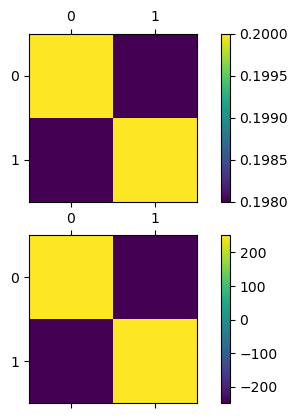

In [6]:
fig, ax = plt.subplots(2,1)
#ax = fig.add_subplot(111)
cax = ax[0].matshow(penalising_covmatrix)  # interpolation='nearest')
fig.colorbar(cax);
cax = ax[1].matshow(penalising_invcovmatrix)  # interpolation='nearest')
fig.colorbar(cax);

In [7]:
%%time
print("corr")
fit_cor = Fit(store_trace=False)
result_cor = fit_cor.run(dataset_cor_N)
        
print("neg")
fit_neg = Fit(store_trace=False)
result_neg = fit_neg.run(dataset_neg_N)

print("pos")
fit_pos = Fit(store_trace=False)
result_pos = fit_pos.run(dataset_pos_N)


corr
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 31.21110672444654 [0.35244887 0.        ]
penality 31.21110672444654 [-0.35244887  0.        ]
penality 0.3121110672444655 [0.03524489 0.        ]
penality 0.3121110672444655 [-0.03524489  0.        ]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 31.21110672444654 [0.         0.35244887]
penality 31.21110672444654 [ 0.         -0.35244887]
penality 0.3121110672444655 [0.         0.03524489]
penality 0.3121110672444655 [ 0.         -0.03524489]
penality 0.003121110672444655 [0.         0.00352449]
penality 0.003121110672444655 [ 0.         -0.00352449]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
pen

penality 7.813095846202919 [ 0.17524234 -0.00110961]
penality 7.813095846202919 [ 0.17524234 -0.00110961]
penality 8.821509122450898 [ 0.18604277 -0.00134617]
penality 13.467041916773319 [ 0.2292445 -0.0022924]
penality 25.95641063206395 [ 0.31723532 -0.00421963]
penality 24.44733548717237 [ 0.30795343 -0.00401633]
penality 24.44733548717237 [ 0.30795343 -0.00401633]
penality 24.44733548717237 [ 0.30795343 -0.00401633]
penality 24.44733548717237 [ 0.30795343 -0.00401633]
penality 24.44733548717237 [ 0.30795343 -0.00401633]
penality 28.005173880766872 [ 0.32988049 -0.00401633]
penality 21.131103196664142 [ 0.28602637 -0.00401633]
penality 24.44733548717237 [ 0.30795343 -0.00401633]
penality 24.44733548717237 [ 0.30795343 -0.00401633]
penality 24.44733548717237 [ 0.30795343 -0.00401633]
penality 24.44733548717237 [ 0.30795343 -0.00401633]
penality 24.337977567648345 [ 0.30795343 -0.003311  ]
penality 24.556943405237508 [ 0.30795343 -0.00472167]
penality 24.44733548717237 [ 0.30795343 -0.

penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 32.974267664418 [0.36226728 0.        ]
penality 32.974267664418 [-0.36226728  0.        ]
penality 0.32974267664418 [0.03622673 0.        ]
penality 0.32974267664418 [-0.03622673  0.        ]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 32.974267664418 [0.         0.36226728]
penality 32.974267664418 [ 0.         -0.36226728]
penality 0.32974267664418 [0.         0.03622673]
penality 0.32974267664418 [ 0.         -0.03622673]
penality 0.0032974267664418002 [0.         0.00362267]
penality 0.0032974267664418002 [ 0.         -0.00362267]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
p

penality 3.1369578198269985 [ 0.02407162 -0.08785419]
penality 3.1369578198269985 [ 0.02407162 -0.08785419]
penality 3.1369578198269985 [ 0.02407162 -0.08785419]
penality 3.10089759212393 [ 0.02407162 -0.08720982]
penality 3.1732267025656715 [ 0.02407162 -0.08849857]
penality 3.1369578198269985 [ 0.02407162 -0.08785419]
penality 3.1369578198269985 [ 0.02407162 -0.08785419]
penality 7.497427682517029 [ 0.0851252  -0.08805005]
penality 11.245567446054356 [ 0.12390068 -0.08817444]
penality 11.245567446054356 [ 0.12390068 -0.08817444]
penality 11.245567446054356 [ 0.12390068 -0.08817444]
penality 11.245567446054356 [ 0.12390068 -0.08817444]
penality 11.245567446054356 [ 0.12390068 -0.08817444]
penality 13.463630605529438 [ 0.14385776 -0.08817444]
penality 9.227647532791837 [ 0.1039436  -0.08817444]
penality 11.245567446054356 [ 0.12390068 -0.08817444]
penality 11.245567446054356 [ 0.12390068 -0.08817444]
penality 11.245567446054356 [ 0.12390068 -0.08817444]
penality 11.245567446054356 [ 0.

penality 0.038327169393411235 [-0.08673635 -0.08755141]
penality 0.03832716973294721 [-0.08673635 -0.08755142]
penality 0.03832716996156635 [-0.08673636 -0.08755142]
penality 0.03832716996156635 [-0.08673636 -0.08755142]
penality 0.03832716996156635 [-0.08673636 -0.08755142]
penality 0.03832716996156635 [-0.08673636 -0.08755142]
penality 0.03832716996156635 [-0.08673636 -0.08755142]
penality 0.12052833153753917 [-0.06858822 -0.08755142]
penality 0.12163096957120913 [-0.10488449 -0.08755142]
penality 0.03832716996156635 [-0.08673636 -0.08755142]
penality 0.03832716996156635 [-0.08673636 -0.08755142]
penality 0.03832716996156635 [-0.08673636 -0.08755142]
penality 0.03832716996156635 [-0.08673636 -0.08755142]
penality 0.03788649703698269 [-0.08673636 -0.08690662]
penality 0.0389767683873742 [-0.08673636 -0.08819621]
penality 0.03832716996156635 [-0.08673636 -0.08755142]
penality 0.03832716996156635 [-0.08673636 -0.08755142]
penality 0.03832716996156635 [-0.08673636 -0.08755142]
penality 0

penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 27.680733314141946 [0.33191764 0.        ]
penality 27.680733314141946 [-0.33191764  0.        ]
penality 0.27680733314141953 [0.03319176 0.        ]
penality 0.27680733314141953 [-0.03319176  0.        ]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 27.680733314141946 [0.         0.33191764]
penality 27.680733314141946 [ 0.         -0.33191764]
penality 0.27680733314141953 [0.         0.03319176]
penality 0.27680733314141953 [ 0.         -0.03319176]
penality 0.0027680733314141954 [0.         0.00331918]
penality 0.0027680733314141954 [ 0.         -0.00331918]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.]
penality 0.0 [0. 0.

penality 730.0452896792845 [-1.58889821  0.11676613]
penality 375.47457936408205 [-1.13105159  0.09225365]
penality 375.47457936408205 [-1.13105159  0.09225365]
penality 375.47457936408205 [-1.13105159  0.09225365]
penality 375.47457936408205 [-1.13105159  0.09225365]
penality 375.47457936408205 [-1.13105159  0.09225365]
penality 375.47457936408205 [-1.13105159  0.09225365]
penality 375.47457936408205 [-1.13105159  0.09225365]
penality 375.47457936408205 [-1.13105159  0.09225365]
penality 375.47457936408205 [-1.13105159  0.09225365]
penality 359.31791046345825 [-1.10445981  0.09225365]
penality 391.9865863523339 [-1.15764337  0.09225365]
penality 375.47457936408205 [-1.13105159  0.09225365]
penality 375.47457936408205 [-1.13105159  0.09225365]
penality 375.47457936408205 [-1.13105159  0.09225365]
penality 375.47457936408205 [-1.13105159  0.09225365]
penality 375.93172825818425 [-1.13105159  0.09300402]
penality 375.01771341244256 [-1.13105159  0.09150328]
penality 375.47457936408205 [-

penality 0.3023954600864535 [0.13156123 0.10093525]
penality 0.16847030447229758 [0.07829786 0.10093525]
penality 0.05723019946625064 [0.10492955 0.10093525]
penality 0.05723019946625064 [0.10492955 0.10093525]
penality 0.05723019946625064 [0.10492955 0.10093525]
penality 0.05723019946625064 [0.10492955 0.10093525]
penality 0.05623213369865494 [0.10492955 0.10171214]
penality 0.05853155727502128 [0.10492955 0.10015837]
penality 0.05723019946625064 [0.10492955 0.10093525]
penality 0.05723019946625064 [0.10492955 0.10093525]
penality 0.05939998297218025 [0.10551928 0.10061195]
penality 0.06747050830724025 [0.10713327 0.09972714]
penality 0.06422528184752503 [0.10655602 0.1000436 ]
penality 0.06422528184752503 [0.10655602 0.1000436 ]
penality 0.06422528184752503 [0.10655602 0.1000436 ]
penality 0.06422528184752503 [0.10655602 0.1000436 ]
penality 0.06422528184752503 [0.10655602 0.1000436 ]
penality 0.06422528184752503 [0.10655602 0.1000436 ]
penality 0.06422528184752503 [0.10655602 0.1000

penality 0.05401566797748032 [0.09636265 0.10089409]
penality 0.05401566797748032 [0.09636265 0.10089409]
penality 0.05401566797748032 [0.09636265 0.10089409]
penality 0.05401566797748032 [0.09636265 0.10089409]
penality 0.05401566797748032 [0.09636265 0.10089409]
penality 0.05401566797748032 [0.09636265 0.10089409]
penality 0.18482093670052388 [0.12297222 0.10089409]
penality 0.2790240936817306 [0.06975308 0.10089409]
penality 0.05401566797748032 [0.09636265 0.10089409]
penality 0.05401566797748032 [0.09636265 0.10089409]
penality 0.05401566797748032 [0.09636265 0.10089409]
penality 0.05401566797748032 [0.09636265 0.10089409]
penality 0.05631194897664505 [0.09636265 0.10167078]
penality 0.05202252806371963 [0.09636265 0.10011739]
penality 0.05401566797748032 [0.09636265 0.10089409]
penality 0.05401566797748032 [0.09636265 0.10089409]
penality 0.054939365932643244 [0.0959017  0.10091224]
penality 0.05978680415123197 [0.09405789 0.10098487]
penality 0.0799739244832663 [0.08944839 0.1011

penality 0.09666579072755296 [0.10360961 0.1156542 ]
penality 0.08694719583320604 [0.10360961 0.11408109]
penality 0.09165104910667983 [0.10360961 0.11486765]
penality 0.09165104910667983 [0.10360961 0.11486765]
penality 0.0774026237529265 [0.10690199 0.1148132 ]
penality 0.0686954683364919 [0.11694205 0.11464717]
penality 0.06717362886300655 [0.11127859 0.11474083]
penality 0.06717362886300655 [0.11127859 0.11474083]
penality 0.06717362886300655 [0.11127859 0.11474083]
penality 0.06717362886300655 [0.11127859 0.11474083]
penality 0.06717362886300655 [0.11127859 0.11474083]
penality 0.17010093346200955 [0.13396519 0.11474083]
penality 0.22288050114977656 [0.08859198 0.11474083]
penality 0.06717362886300655 [0.11127859 0.11474083]
penality 0.06717362886300655 [0.11127859 0.11474083]
penality 0.06717362886300655 [0.11127859 0.11474083]
penality 0.06717362886300655 [0.11127859 0.11474083]
penality 0.06913860154727465 [0.11127859 0.11552784]
penality 0.06551990659576704 [0.11127859 0.11395

penality 0.06584168289758505 [0.11344273 0.11474793]
penality 0.06584168289758505 [0.11344273 0.11474793]
penality 0.06584168289758505 [0.11344273 0.11474793]
penality 0.07069202430762905 [0.11799695 0.11474793]
penality 0.07141389601348333 [0.10888852 0.11474793]
penality 0.06597794681751847 [0.11435358 0.11474793]
penality 0.06612232115868931 [0.11253189 0.11474793]
penality 0.06584168289758505 [0.11344273 0.11474793]
penality 0.06584168289758505 [0.11344273 0.11474793]
penality 0.06584168289758505 [0.11344273 0.11474793]
penality 0.06584168289758505 [0.11344273 0.11474793]
penality 0.06584168289758505 [0.11344273 0.11474793]
penality 0.06584168289758505 [0.11344273 0.11474793]
penality 0.06604085138567818 [0.11344273 0.11490531]
penality 0.06565496170313126 [0.11344273 0.11459054]
penality 0.06584168289758505 [0.11344273 0.11474793]
penality 0.06584168289758505 [0.11344273 0.11474793]
penality 0.06584168289758505 [0.11344273 0.11474793]
penality 0.19431893520722782 [0.13621381 0.114

/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


penality 116375.45347957492 [21.62327808  0.1028265 ]
penality 1333.9373231941413 [2.41642327 0.11347154]
penality 3.3917764358701508 [0.22859176 0.11468411]
penality 0.0741704614834115 [0.11935814 0.11474465]
penality 0.0741704614834115 [0.11935814 0.11474465]
penality 0.0741704614834115 [0.11935814 0.11474465]
penality 0.0741704614834115 [0.11935814 0.11474465]
penality 0.0741704614834115 [0.11935814 0.11474465]
penality 0.0741704614834115 [0.11935814 0.11474465]
penality 0.0741704614834115 [0.11935814 0.11474465]
penality 0.1213839600223846 [0.12846657 0.11474465]
penality 0.06864718104820756 [0.11024971 0.11474465]
penality 0.2700189863504259 [0.14210449 0.11474465]
penality 0.13832020776961906 [0.09661179 0.11474465]
penality 0.0741704614834115 [0.11935814 0.11474465]
penality 0.0741704614834115 [0.11935814 0.11474465]
penality 0.0741704614834115 [0.11935814 0.11474465]
penality 0.0741704614834115 [0.11935814 0.11474465]
penality 0.07297368665292792 [0.11935814 0.11553157]
penalit

penality 0.34568451801660427 [0.09572454 0.12931403]
penality 0.26882616439612694 [0.09622911 0.12502674]
penality 0.26882616439612694 [0.09622911 0.12502674]
penality 0.26882616439612694 [0.09622911 0.12502674]
penality 0.26882616439612694 [0.09622911 0.12502674]
penality 0.26882616439612694 [0.09622911 0.12502674]
penality 0.09365937901374796 [0.11592194 0.12502674]
penality 0.6388711574531946 [0.07653628 0.12502674]
penality 0.26882616439612694 [0.09622911 0.12502674]
penality 0.26882616439612694 [0.09622911 0.12502674]
penality 0.26882616439612694 [0.09622911 0.12502674]
penality 0.26882616439612694 [0.09622911 0.12502674]
penality 0.26882616439612694 [0.09622911 0.12502674]
penality 0.26882616439612694 [0.09622911 0.12502674]
penality 0.2808204775911404 [0.09622911 0.12581826]
penality 0.25714667346183084 [0.09622911 0.12423523]
penality 0.26882616439612694 [0.09622911 0.12502674]
penality 0.26882616439612694 [0.09622911 0.12502674]
penality 0.08413243769491673 [0.11784658 0.12431

penality 0.05647066037887179 [0.10610487 0.10588892]
penality 0.05573135560639534 [0.10539853 0.10520749]
penality 0.054160776571832714 [0.10388136 0.10374381]
penality 0.05455489857603334 [0.10426425 0.1041132 ]
penality 0.05455489857603334 [0.10426425 0.1041132 ]
penality 0.05455489857603334 [0.10426425 0.1041132 ]
penality 0.05455489857603334 [0.10426425 0.1041132 ]
penality 0.05455489857603334 [0.10426425 0.1041132 ]
penality 0.16668677645443528 [0.12423113 0.1041132 ]
penality 0.14276305694701968 [0.08429736 0.1041132 ]
penality 0.05455489857603334 [0.10426425 0.1041132 ]
penality 0.05455489857603334 [0.10426425 0.1041132 ]
penality 0.05455489857603334 [0.10426425 0.1041132 ]
penality 0.05455489857603334 [0.10426425 0.1041132 ]
penality 0.05505971304150974 [0.10426425 0.10489615]
penality 0.0543581299616155 [0.10426425 0.10333025]
penality 0.05455489857603334 [0.10426425 0.1041132 ]
penality 0.05455489857603334 [0.10426425 0.1041132 ]
penality 0.05322839085564732 [0.10292432 0.102

penality 0.020384859867964854 [0.06329846 0.06384806]
penality 0.01116981695682388 [0.04726482 0.04679243]
penality 0.01536818369345641 [0.05528164 0.05532025]
penality 0.019321589055879697 [0.06170352 0.06215146]
penality 0.01858826987498965 [0.06057413 0.06095009]
penality 0.017688668342010598 [0.05915312 0.0594385 ]
penality 0.018104740546754993 [0.0598154 0.060143 ]
penality 0.018104740546754993 [0.0598154 0.060143 ]
penality 0.018104740546754993 [0.0598154 0.060143 ]
penality 0.018104740546754993 [0.0598154 0.060143 ]
penality 0.018104740546754993 [0.0598154 0.060143 ]
penality 0.1180424888903052 [0.07948717 0.060143  ]
penality 0.11262856306572003 [0.04014363 0.060143  ]
penality 0.018104740546754993 [0.0598154 0.060143 ]
penality 0.018104740546754993 [0.0598154 0.060143 ]
penality 0.018104740546754993 [0.0598154 0.060143 ]
penality 0.018104740546754993 [0.0598154 0.060143 ]
penality 0.018602365995055308 [0.0598154  0.06090175]
penality 0.017896418364680977 [0.0598154  0.05938424

In [8]:
datasets_short = [dataset_neg_N, dataset_cor_N, dataset_pos_N]
print("best fit amplitude")
amplitudes_N = []
m = dataset_asimov.models[0]
value = m.parameters['amplitude'].value 
error = m.parameters['amplitude'].error
amplitudes_N.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    m = d.models[0]
    value = m.parameters['amplitude'].value 
    error = m.parameters['amplitude'].error
    amplitudes_N.append((value, error))
    print(f'{value} pm {error}')
print()
print("best fit Index")
indices_N = []
m = dataset_asimov.models[0]
value = m.parameters['index'].value 
error = m.parameters['index'].error
indices_N.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    m = d.models[0]
    value = m.parameters['index'].value 
    error = m.parameters['index'].error
    indices_N.append((value, error))
    print(f'{value} pm {error}')
print()

print("Best Fit bkg Norm")
norms_N = []
value = dataset_asimov.background_model.parameters['norm'].value 
error = dataset_asimov.background_model.parameters['norm'].error
norms_N.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    value = d.background_model.parameters['norm'].value 
    error = d.background_model.parameters['norm'].error
    print(f'{value} pm {error}')
    norms_N.append((value, error))
    

best fit amplitude
====
Input
1e-12 pm 0.0
====
9.141407960790216e-13 pm 1.0959679309725987e-13
1.0009629910058658e-12 pm 1.1544525820363773e-13
1.1884521946466897e-12 pm 2.382969810975227e-13

best fit Index
====
Input
2.3 pm 0.0
====
2.3006575288705085 pm 0.061508577671347466
2.3007403086171343 pm 0.06153976240056211
2.3006426274177314 pm 0.061375649156378

Best Fit bkg Norm
====
Input
1.0 pm 0
====
0.9132846293352108 pm 0.021210254642258876
1.0011319333908755 pm 0.023316417963575413
1.1865956256383332 pm 0.20686404543711848


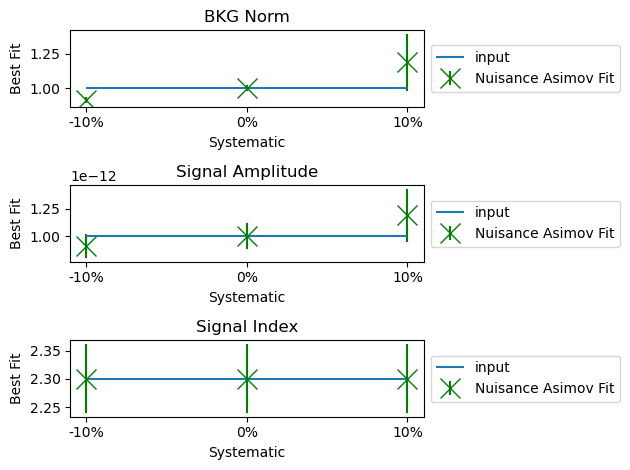

In [9]:
fig, axs = plt.subplots(3,1)

axs[0].set_title("BKG Norm")
axs[1].set_title("Signal Amplitude")
axs[2].set_title("Signal Index")


labels_sys = [ '-10%', '0%', '10%']
label = "Nuisance Asimov Fit"

for i, a in enumerate(norms_N[1:]):
    axs[0].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[0].hlines( norms_N[0][0], 1, 3, label = "input")

for i, a in enumerate(amplitudes_N[1:]):
    axs[1].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[1].hlines( amplitudes_N[0][0], 1, 3, label = "input")

for i, a in enumerate(indices_N[1:]):
    axs[2].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[2].hlines( indices_N[0][0], 1, 3, label = "input")

plt.tight_layout()
for a in axs:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    a.legend(by_label.values(), by_label.keys(),
            loc='center left', bbox_to_anchor=(1, 0.5))
    a.set_ylabel('Best Fit'); 
    a.set_xlabel('Systematic'); 
    a.set_xticks(np.arange(3)+1,labels_sys)

plt.tight_layout()    
fig.savefig("best_fit_parameters_corr.pdf")   


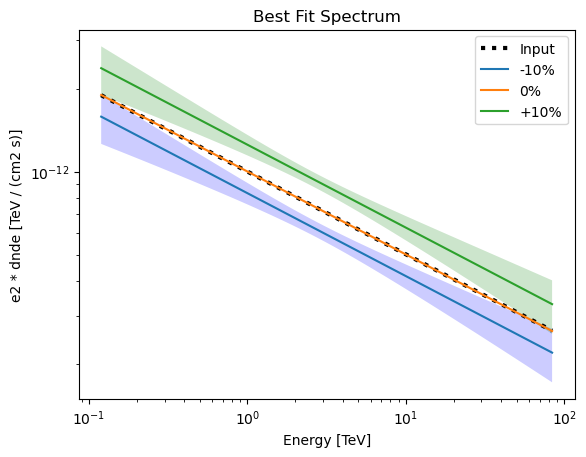

In [10]:
true_energy = dataset_cor_N.exposure.geom.axes[0].center.value


fig,ax = plt.subplots()
energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV
dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 3, linestyle ='dotted')

dataset_neg_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "-10%")
dataset_neg_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                       facecolor='blue')

dataset_cor_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "0%")
                                   
#dataset_cor_N.models['Source'].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
#                                                       facecolor='orange')


                               
dataset_pos_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "+10%")
dataset_pos_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                        facecolor = 'green')


plt.legend()

plt.title("Best Fit Spectrum")
fig = plt.gcf()
#fig.savefig("plots/2_spectrum.pdf")

-0.08673635511315228
-0.0005560447825046829
0.052972880717028076
-0.0875514154118781
-0.001130988644517131
0.05340379420794093


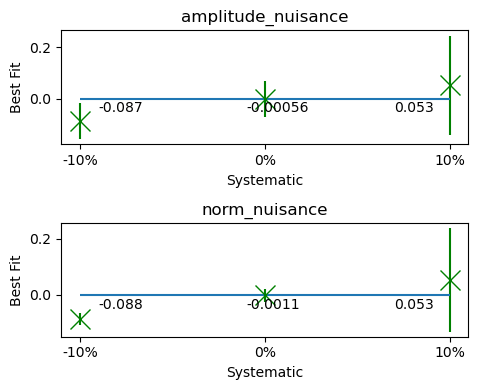

In [11]:
n_nui = len(dataset_neg_N.models.parameters.penalised_parameters)
fig, a  = plt.subplots(n_nui, 1, figsize = (5,2* n_nui))
label = 'Nuisance Fit'
iss = [1.1, 1.9, 2.7]
for j, par_name in enumerate(dataset_neg_N.models.parameters.penalised_parameters.names):
    for i, d in enumerate([dataset_neg_N, dataset_cor_N, dataset_pos_N]):
        value = d.models.parameters[par_name].value
        error = d.models.parameters[par_name].error
        print(value)

        a[j].errorbar(x= i+1, y = value, yerr = error, fmt= 'x', color =  'green',markersize=14,
                       label = label)
        a[j].text(iss[i],-0.05, f'{value:.2}', )
    a[j].hlines( 0., 1, 3, label = "input")

    a[j].set_ylabel('Best Fit' ); 
    a[j].set_title(par_name)
    a[j].set_xlabel('Systematic'); 
    a[j].set_xticks(np.arange(3)+1,labels_sys);

plt.tight_layout()
#fig.savefig("plots/2_best_fit_nui.pdf")

## Comparison

In [12]:

with open('data/norms.yaml') as file:
    norms = yaml.load( file, Loader=yaml.FullLoader)
with open('data/amplitudes.yaml') as file:
    amplitudes = yaml.load( file, Loader=yaml.FullLoader)
with open('data/indices.yaml') as file:
    indices = yaml.load( file, Loader=yaml.FullLoader)
    


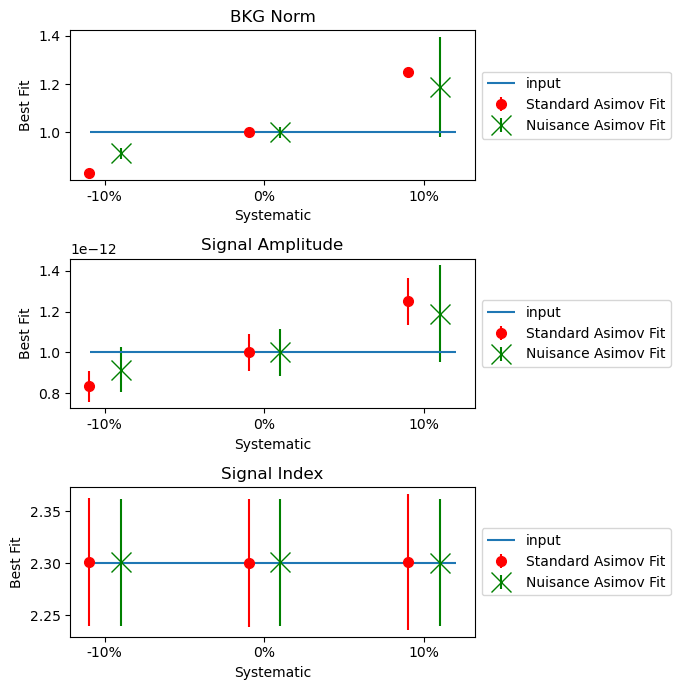

In [13]:
fig, axs = plt.subplots(3,1, figsize= (7, 7))

axs[0].set_title("BKG Norm")
axs[1].set_title("Signal Amplitude")
axs[2].set_title("Signal Index")


labels_sys = [ '-10%', '0%', '10%']

for i, a in enumerate(norms[1:]):
    label = "Standard Asimov Fit"
    axs[0].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                   label = label)
for i, a in enumerate(amplitudes[1:]):
    axs[1].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                   label = label)
for i, a in enumerate(indices[1:]):
    axs[2].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                   label = label)
    
for i, a in enumerate(norms_N[1:]):
    label = "Nuisance Asimov Fit"
    axs[0].errorbar(x= i+1.1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
for i, a in enumerate(amplitudes_N[1:]):
    axs[1].errorbar(x= i+1.1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
for i, a in enumerate(indices_N[1:]):
    axs[2].errorbar(x= i+1.1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[2].hlines( indices[0][0], 0.91, 3.2, label = "input")
axs[0].hlines( norms[0][0], 0.91, 3.2, label = "input")
axs[1].hlines( amplitudes[0][0], 0.91, 3.2, label = "input")

plt.tight_layout()
for ax in axs:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), ncol = 1, 
            loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylabel('Best Fit'); 
    ax.set_xlabel('Systematic'); 
    ax.set_xticks(np.arange(3)+1,labels_sys)

    
#axs[0].set_ylim(0.85, 1.15)
plt.tight_layout()    
fig.savefig("plots/2_best_fit_parameters_comparison.pdf")   


### Spectrum

In [14]:
dataset_st_neg = dataset_neg_N.copy()
dataset_st_neg.models = Models.read("data/1_model_neg.yml")

dataset_st_pos = dataset_pos_N.copy()
dataset_st_pos.models = Models.read("data/1_model_pos.yml")

dataset_st_cor = dataset_cor_N.copy()
dataset_st_cor.models = Models.read("data/1_model_cor.yml")

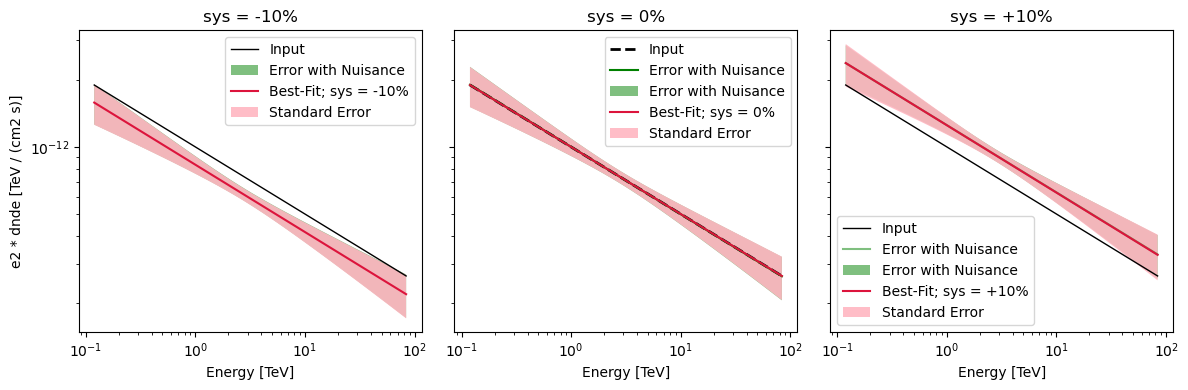

In [15]:
true_energy = dataset_cor_N.exposure.geom.axes[0].center.value
energy_bounds = (true_energy[0], true_energy[-1] ) * u.TeV
fig,axs = plt.subplots(1,3, sharey=True,figsize = (12,4))

for i,ax in enumerate(axs):
    if i ==1:
         dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 2, linestyle="dashed")
    else:
        dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 1, )

dataset_neg_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[0],
                                                       facecolor='green',
                                                         label="Error with Nuisance",
                                                        alpha = 0.5)
dataset_st_neg.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[0],
                                label = "Best-Fit; sys = -10%", color = "crimson")
dataset_st_neg.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[0],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )
### cor 
dataset_cor_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[1],
                                                       color='green',
                                                         label="Error with Nuisance",
                                                        alpha = 1.0)
dataset_cor_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[1],
                                                       facecolor='green',
                                                         label="Error with Nuisance",
                                                        alpha = 0.5)
dataset_st_cor.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[1],
                                label = "Best-Fit; sys = 0%", color = "crimson")
dataset_st_cor.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[1],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )
### pos 
dataset_pos_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[2],
                                                       color='green',
                                                         label="Error with Nuisance",
                                                        alpha = 0.5)
dataset_pos_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[2],
                                                       facecolor='green',
                                                         label="Error with Nuisance",
                                                        alpha = 0.5)
dataset_st_pos.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[2],
                                label = "Best-Fit; sys = +10%", color = "crimson")
dataset_st_pos.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[2],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )
[a.legend() for a in axs]
axs[0].set_title("sys = -10%"); axs[1].set_title("sys = 0%"); axs[2].set_title("sys = +10%"); 

axs[1].set_ylabel('')
axs[2].set_ylabel('')

plt.tight_layout()
fig = plt.gcf()
fig.savefig("plots/2_spectrum.pdf")

<AxesSubplot: >

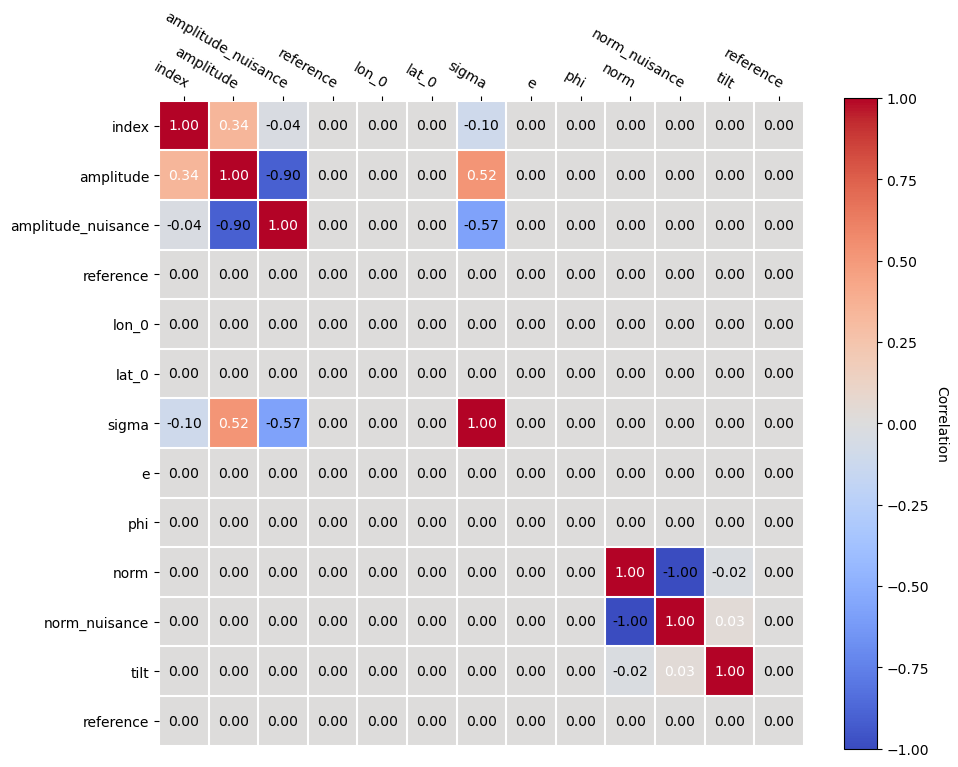

In [16]:
dataset_pos_N.models.covariance.plot_correlation()

unique_pars ['index', 'amplitude', 'amplitude_nuisance', 'reference', 'lon_0', 'lat_0', 'sigma', 'e', 'phi', 'norm', 'norm_nuisance', 'tilt', 'reference']
parameters ['index', 'amplitude', 'amplitude_nuisance', 'reference', 'lon_0', 'lat_0', 'sigma', 'e', 'phi', 'norm', 'norm_nuisance', 'tilt', 'reference']


<AxesSubplot: >

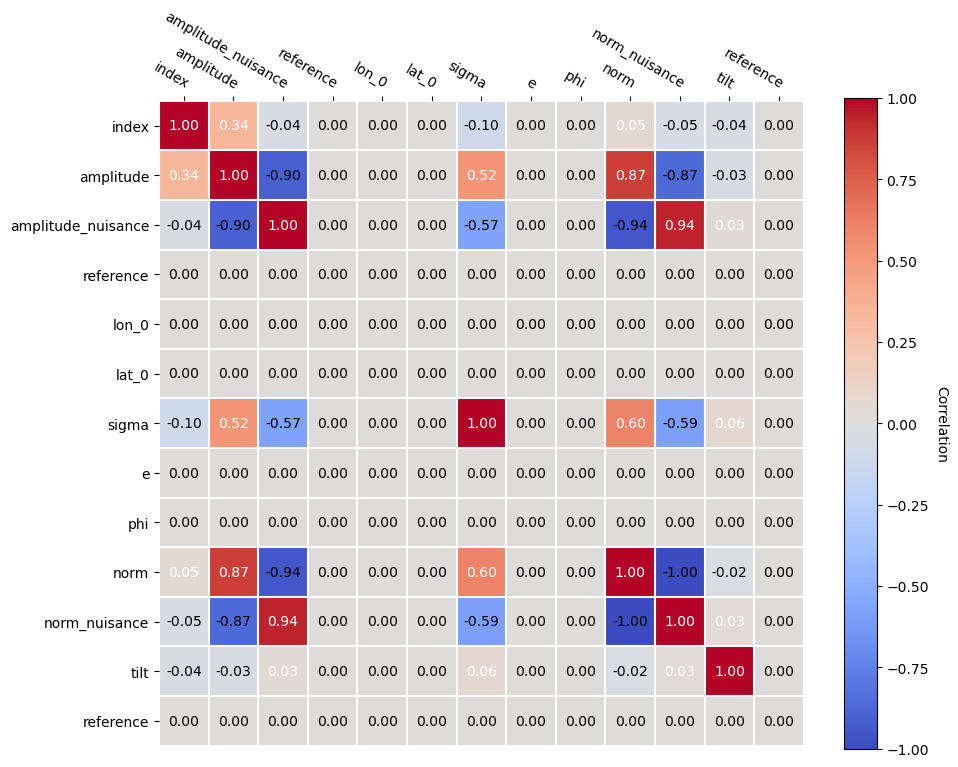

In [17]:
dataset_pos_N.models.covariance = fit_pos.covariance(dataset_pos_N).matrix
dataset_pos_N.models.covariance.plot_correlation()

In [18]:
from gammapy.stats import  gaussian_penality
values = np.linspace(-0.1, 0.1, 10)
pen = []
stat = []
for v in values:
    dataset_pos_N.models.parameters['norm_nuisance'].value = v
    dataset_pos_N.models.parameters['amplitude_nuisance'].value = v
    
    penalty = gaussian_penality(dataset_pos_N.models.parameters.penalised_parameters,
                                     dataset_pos_N._penalising_invcovmatrix)
    stat_sum = dataset_pos_N.stat_sum()  - penalty
    
    pen.append(penalty)
    stat.append(stat_sum)
pen = np.array(pen)
stat = np.array(stat)  



penality 0.05025125628140658 [-0.1 -0.1]
penality 0.03039890812085104 [-0.07777778 -0.07777778]
penality 0.015509647000434248 [-0.05555556 -0.05555556]
penality 0.005583472920156307 [-0.03333333 -0.03333333]
penality 0.0006203858800173642 [-0.01111111 -0.01111111]
penality 0.0006203858800173642 [0.01111111 0.01111111]
penality 0.0055834729201563035 [0.03333333 0.03333333]
penality 0.015509647000434246 [0.05555556 0.05555556]
penality 0.03039890812085104 [0.07777778 0.07777778]
penality 0.05025125628140658 [0.1 0.1]


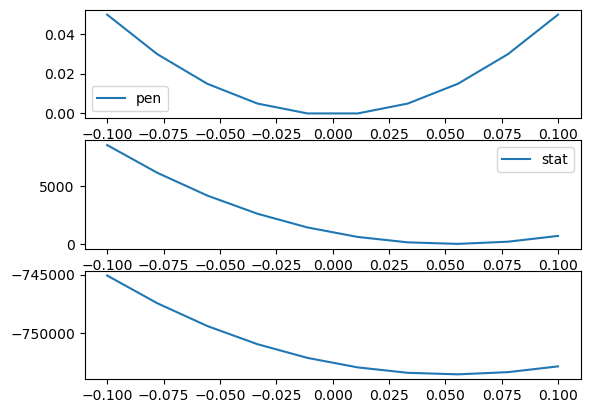

In [19]:
fig, ax = plt.subplots(3,1)
ax[0].plot(values, pen - np.min(pen), label= 'pen')
ax[1].plot(values, stat - np.min(stat), label= 'stat')
ax[2].plot(values, stat +pen , label= 'stat +pen')

ax[1].legend()
ax[0].legend()